# Load the image dataset

In [ ]:
!nvidia-smi

Thu Oct 28 07:37:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
from tensorflow.keras import layers

from sklearn import metrics

ROOT = '/path/to/unzip/to/Dataset/'
save_location = '/path/to/save/Comprehensive Disaster Dataset/models/'

!ls drive/MyDrive/Project\ Datasets/Image\ Data/CDD

'Comprehensive Disaster Dataset.zip'   models


In [ ]:
# -q: quiet; -qq: even quieter
!unzip -qq '/path/to/zip/file/Comprehensive Disaster Dataset.zip' -d '/path/to/unzip/to/Dataset/'

## Helper Functions

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
def splitIntoTrainAndTest(test_sz=0.2):
  classes = os.listdir(ROOT)

  os.mkdir(ROOT+'train')
  os.mkdir(ROOT+'test')

  for class_ in classes:
    os.mkdir(ROOT+'train/'+class_)
    os.mkdir(ROOT+'test/'+class_)

  print('Moving files...')

  for class_ in classes:
    all_files = os.listdir(ROOT+class_)
    total = len(all_files)

    train_files, test_files = all_files[:total-int(test_sz*total)], all_files[total-int(test_sz*total):]

    for file in train_files:
      src, dest = ROOT+class_+f'/{file}', ROOT+f'train/{class_}/'
      shutil.move(src, dest)

    for file in test_files:
      src, dest = ROOT+class_+f'/{file}', ROOT+f'test/{class_}/'
      shutil.move(src, dest)
  
  print('Files Moved!')
  
  for class_ in classes:
    os.rmdir(ROOT+class_)

## Split Data into train and test sets

In [ ]:
prompt = input('split dataset into train and test? (y/n):')
print()
if prompt=='y':
  splitIntoTrainAndTest(test_sz=0.3)

split dataset into train and test? (y/n):y

Moving files...
Files Moved!


# Data Augmentation

In [21]:
BATCH_SIZE = 64
IMAGE_SHAPE = (396, 465)
slack = 0.5

train_datagen = ImageDataGenerator(
    rescale=1/255.,
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

print('Training images:')
train_data = train_datagen.flow_from_directory(
    ROOT+'train',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print('Testing images:')
test_data = train_datagen.flow_from_directory(
    ROOT+'test',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Training images:
Found 9493 images belonging to 12 classes.
Testing images:
Found 4062 images belonging to 12 classes.


## TFHub Model URLs

In [ ]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

## Build Model

In [ ]:
def build_model(model_url, num_classes=12):
  feature_extractor_layer = hub.KerasLayer(
      model_url,
      trainable=False,
      name='feature_extraction_layer',
      input_shape=IMAGE_SHAPE+(3,)
  )

  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')      
  ])

  return model

## Load and fit model

### 1. ResNet V2 50

In [ ]:
# load model
model = build_model(resnet_url)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 12)                24588     
Total params: 23,589,388
Trainable params: 24,588
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
(model.input_shape, model.output_shape)

((None, 396, 465, 3), (None, 12))

In [ ]:
history = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 1/3
149/149 [==============================] - 337s 2s/step - loss: 0.5433 - accuracy: 0.8492 - val_loss: 0.2548 - val_accuracy: 0.9259
Epoch 2/3
149/149 [==============================] - 290s 2s/step - loss: 0.1959 - accuracy: 0.9410 - val_loss: 0.2094 - val_accuracy: 0.9338
Epoch 3/3
149/149 [==============================] - 290s 2s/step - loss: 0.1483 - accuracy: 0.9540 - val_loss: 0.1882 - val_accuracy: 0.9402


In [ ]:
model.evaluate(test_data)

64/64 [==============================] - 88s 1s/step - loss: 0.1882 - accuracy: 0.9402


[0.18815423548221588, 0.9401772618293762]

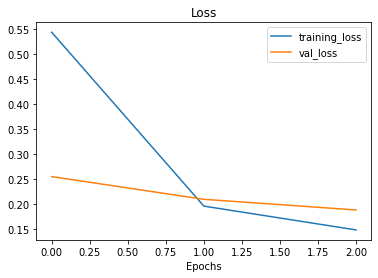

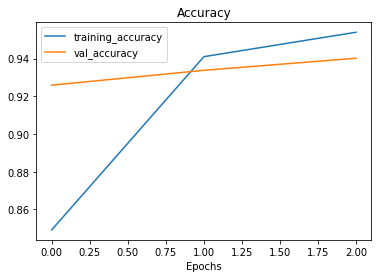

In [ ]:
plot_loss_curves(history)

In [19]:
model.save(save_location+'ResNet-V2-50')

### 2. EfficientNet B3

In [ ]:
# load model
model = build_model(efficientnet_url)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1536)              10783528  
_________________________________________________________________
output_layer (Dense)         (None, 12)                18444     
Total params: 10,801,972
Trainable params: 18,444
Non-trainable params: 10,783,528
_________________________________________________________________


In [ ]:
(model.input_shape, model.output_shape)

((None, 396, 465, 3), (None, 12))

In [ ]:
history = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
)

Epoch 1/3
149/149 [==============================] - 398s 2s/step - loss: 0.4946 - accuracy: 0.8776 - val_loss: 0.2321 - val_accuracy: 0.9404
Epoch 2/3
149/149 [==============================] - 342s 2s/step - loss: 0.1792 - accuracy: 0.9509 - val_loss: 0.1869 - val_accuracy: 0.9481
Epoch 3/3
149/149 [==============================] - 347s 2s/step - loss: 0.1380 - accuracy: 0.9593 - val_loss: 0.1701 - val_accuracy: 0.9515


In [ ]:
model.evaluate(test_data)

64/64 [==============================] - 105s 2s/step - loss: 0.1701 - accuracy: 0.9515


[0.17008236050605774, 0.951501727104187]

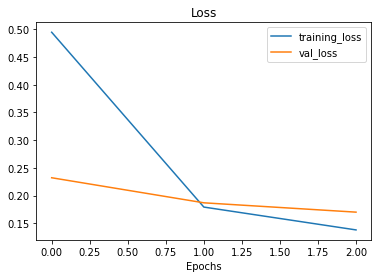

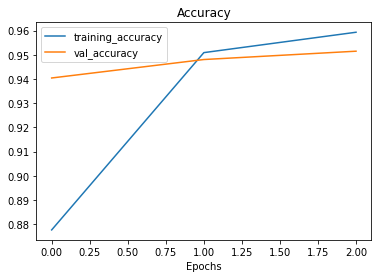

In [ ]:
plot_loss_curves(history)

In [20]:
model.save(save_location+'EfficientNet-B3')

## Mapping

```python
mapping = {
    'Damaged Infrastructure': 0,
    'Drought': 1,
    'Earthquake': 2,
    'Injured Human': 3,
    'Land Slide': 4,
    'Safe Forest': 5,
    'Safe Human': 6,
    'Safe Infrastructure': 7,
    'Safe Water': 8,
    'Urban Fire': 9,
    'Water Disaster': 10,
    'Wild Fire': 11
}


# make sure test data is of dimension: (N x 396 x 465 x 3)
class_index = np.argmax(
  model.predict(test_data)
)

# gets you the predicted class's name
class_name = mapping[class_index]
```